In [48]:
library(tidyverse)
library(class)

set.seed(41)
library(caret)
# Run the following line if the confusion matrix gives you trouble
#install.packages('e1071', dependencies=TRUE)

## In this notebook we will explore what the K-Nearest-Neighbors classifier is and we will fit it to the breast cancer dataset.

# I - Explaining the algorithm.

### KNN is a supervized classification model.

## Step 1: Calculate the distance between the data point to classify and each data point in our training set.

### We usually use Euclidean distance (the square root of the sum of the squares of each coordinate for two given points).
![](https://i.stack.imgur.com/VxSuL.png "Euclidean")


## Step 2: Take the K closest points from the training set to our data point and classify it as the mode of those k points (the majority class).

# We could use KNN to classify a point using the data below by applying the steps above.

![](https://miro.medium.com/max/1180/1*Xo-oGP0Fb0217QuiWZrheQ.png "Classes")

# II - Getting the data ready before fitting.

In [49]:
# Here is a function that gives us a train validate test set
trainTestSplit <- function(tib, train=0.6, validation=0.2, test=0.2) {
    if ((train + validation + test) != 1.0) {
        return ("Oops... Train, test and validation need to add up to 1.")
    }
    
    trainSet <- tib %>%
        sample_frac(train)
    
    validationSet <- tib %>%
        anti_join(trainSet, by="id") %>%
        sample_frac(validation / (1 - train))
    
    testSet <- tib %>%
        anti_join(trainSet, by="id") %>%
        anti_join(validationSet, by="id")
    
    return (list(trainSet, validationSet, testSet))
}

In [50]:
# Reading in our data and adding an ID for splitting
cancer <- read_csv('breast_cancer.csv', col_types = cols())
cancer <- cancer %>%
    mutate(id = row_number())

# Getting our splits
splits <- trainTestSplit(cancer, train=0.6, validation=0.2, test=0.2)

# Separating our splits into train, validate and split
train <- splits[[1]]
validate <- splits[[2]]
test <- splits[[3]]

In [51]:
# Separating our splits into predictors and predicted variables
trainX <- train[, -c(6, 7)]
trainY <- train[, 'diagnosis']

validateX <- validate[, -c(6, 7)]
validateY <- validate[, 'diagnosis']

testX <- test[, -c(6, 7)]
testY <- test[, 'diagnosis']

# III - Fitting KNN to the breast cancer dataset.
Data fetched from [Kaggle (Merishna Singh Suwal, 2018)](https://www.kaggle.com/merishnasuwal/breast-cancer-prediction-dataset)

In [52]:
# We will use these two to draw a plot of accuracy for different values of k
ks <- c()
accuracies <- c()

# We will update these to keep track of the best accuracy we see
max_accuracy <- 0
best_k <- 0
best_classifications <- c()

# For every possible value of k
for(k in seq(1, 341)) {
    # Update the index
    ks[k] <- k
    
    # Run the model with k=k and compute the accuracy
    modelk <- knn(train=trainX, test = validateX, cl = trainY$diagnosis, k=k)
    accuracy <- mean(validateY$diagnosis == modelk)
    
    # Save the accuracy for later
    accuracies[k] <- accuracy
    
    # If this is the best accuracy we've seen
    if (accuracy > max_accuracy) {
        # Keep track of the accuracy and the k that got us there
        max_accuracy <- accuracy
        best_k <- k
        best_classifications <- modelk
    }
}

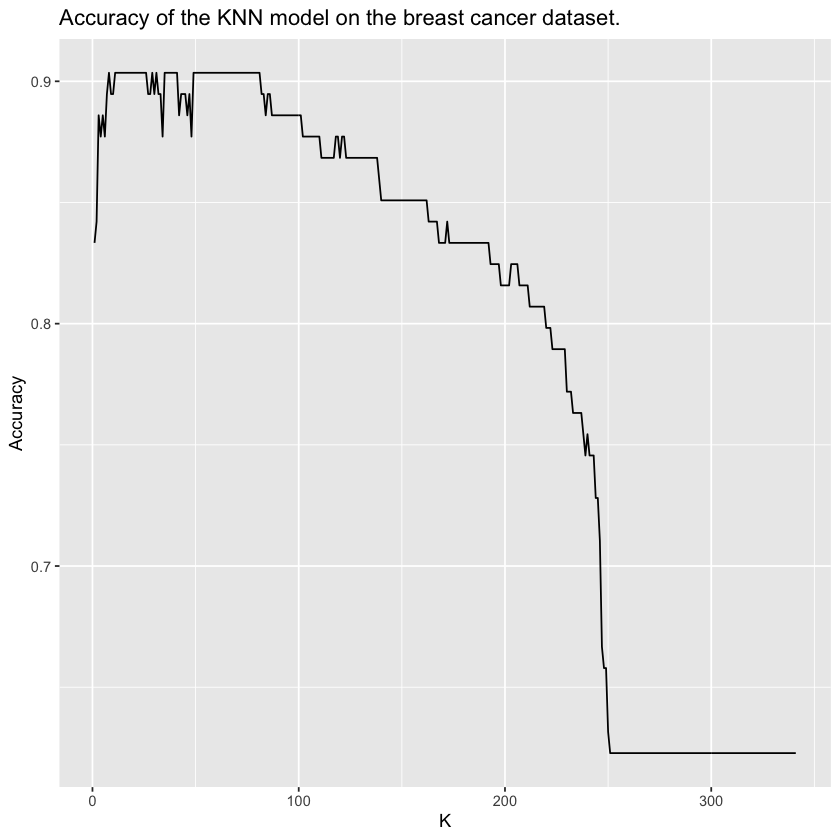

In [53]:
# Let's draw a plot of the accuracy for different values of K.
ggplot() +
    geom_line(map = aes(x = ks, y = accuracies)) +
    ggtitle('Accuracy of the KNN model on the breast cancer dataset.') +
    ylab('Accuracy') +
    xlab('K')

In [54]:
# Now we can get the best accuracy on our validation set and the best K.
max_accuracy
best_k

[1] 0.9035088

[1] 8

### Our best accuracy on the validation set is ~90% with k=8.
### Let's also create a confusion matrix to further assess the quality of our model.

In [55]:
confusionMatrix(data = best_classifications, reference = factor(validateY$diagnosis))

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 33  1
         1 10 70
                                          
               Accuracy : 0.9035          
                 95% CI : (0.8339, 0.9508)
    No Information Rate : 0.6228          
    P-Value [Acc > NIR] : 1.124e-11       
                                          
                  Kappa : 0.7858          
                                          
 Mcnemar's Test P-Value : 0.01586         
                                          
            Sensitivity : 0.7674          
            Specificity : 0.9859          
         Pos Pred Value : 0.9706          
         Neg Pred Value : 0.8750          
             Prevalence : 0.3772          
         Detection Rate : 0.2895          
   Detection Prevalence : 0.2982          
      Balanced Accuracy : 0.8767          
                                          
       'Positive' Class : 0               
                                    

### If we observe the confusion matrix, we can see that we only have 1 false negative, most of our error is the 10 false positives we have classified, so we believe that this model is a good one for predicting breast cancer from this dataset. We also observe that balanced accuracy falls to ~88%, but that is still pretty good.

### We will therefore apply KNN with K=8 to our testing set.

In [58]:
# Getting the predictions for the test set
predictions <- knn(train=trainX, test = testX, cl = trainY$diagnosis, k=8)

# Getting the accuracy for the test set
testAccuracy <- mean(testY$diagnosis == predictions)

In [57]:
testAccuracy

[1] 0.8070175

### We get a testing accuracy of 81% and we are pretty happy with this number! Let's also have a look at the confusion matrix:

In [59]:
confusionMatrix(data = predictions, reference = factor(testY$diagnosis))

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 27  6
         1 16 65
                                          
               Accuracy : 0.807           
                 95% CI : (0.7225, 0.8749)
    No Information Rate : 0.6228          
    P-Value [Acc > NIR] : 1.703e-05       
                                          
                  Kappa : 0.5695          
                                          
 Mcnemar's Test P-Value : 0.05501         
                                          
            Sensitivity : 0.6279          
            Specificity : 0.9155          
         Pos Pred Value : 0.8182          
         Neg Pred Value : 0.8025          
             Prevalence : 0.3772          
         Detection Rate : 0.2368          
   Detection Prevalence : 0.2895          
      Balanced Accuracy : 0.7717          
                                          
       'Positive' Class : 0               
                                    

### We observe that our false negatives are still low, but why the lower accuracy?

### Our hypothesis is that the low number of data points in this dataset are what affects our testing accuracy, we believe that having more data to train with and also more to test it would help us achieve a better model.